In [1]:
import project_metrics.project_metrics as metrics
import numpy as np
import pandas as pd
import pickle
from os.path import exists

In [2]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv("train.csv")
df_val= pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df_train.drop("INDEX", inplace=True, axis =1)
df_val.drop("INDEX", inplace=True, axis =1)
df_test.drop("INDEX", inplace=True, axis =1)

df_train.drop("Unnamed: 0", inplace=True, axis =1)
df_val.drop("Unnamed: 0", inplace=True, axis =1)
df_test.drop("Unnamed: 0", inplace=True, axis =1)

df_train.drop("IND_BOM_1_2", inplace=True, axis =1)
df_val.drop("IND_BOM_1_2", inplace=True, axis =1)
df_test.drop("IND_BOM_1_2", inplace=True, axis =1)

In [5]:
y_train = df_train["IND_BOM_1_1"].values
y_val = df_val["IND_BOM_1_1"].values
y_test = df_test["IND_BOM_1_1"].values

In [6]:
df_train.drop("IND_BOM_1_1", inplace=True, axis =1)
df_val.drop("IND_BOM_1_1", inplace=True, axis =1)
df_test.drop("IND_BOM_1_1", inplace=True, axis =1)

In [7]:
X_train = df_train.values
X_val = df_val.values
X_test = df_test.values

In [8]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

# Final Project

## Gradient-boosting

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import keras


MODELS_PATH = "Models/MLP"
HISTORY_PATH = f"{MODELS_PATH}/history"
MODEL_PATH = f"{MODELS_PATH}/model"

In [10]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

In [11]:
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

### Experimento Inicial

C:\Users\marco\AppData\Local\Temp\ipykernel_8484\2645845749.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model,


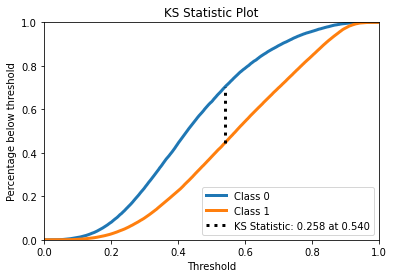

Performance no conjunto de validação:

Accuracy:         0.6263
Recall:           0.6184
Precision:        0.6283
F1:               0.6233
AUROC:            0.6763
AUPR:             0.6725


In [12]:
mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)
mlp_clf.fit(X_train, y_train)
mlp_pred_class = mlp_clf.predict(X_val)
mlp_pred_scores = mlp_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Vamos fazer a testagem agora com todos os parametros do GradientBoostingClassifier no default

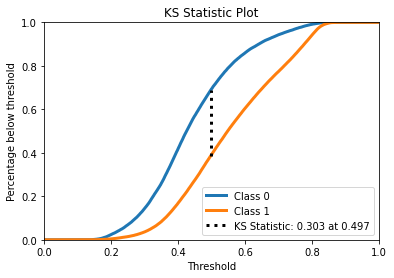


Accuracy:         0.6513
Recall:           0.6089
Precision:        0.6653
F1:               0.6359
AUROC:            0.7093
AUPR:             0.7033


In [13]:
gb_clf = GradientBoostingClassifier()  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

### Experimento Posteriores

Vamos agora modificar os parametros para conseguirmos diferentes resultados 

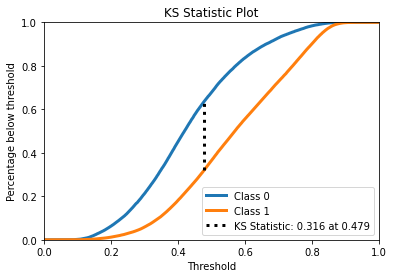


Accuracy:         0.6569
Recall:           0.6355
Precision:        0.6639
F1:               0.6494
AUROC:            0.7170
AUPR:             0.7116


In [14]:
gb_clf = GradientBoostingClassifier(n_estimators=500)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

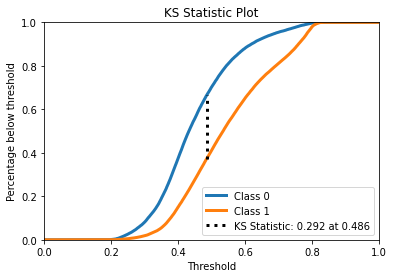


Accuracy:         0.6459
Recall:           0.5899
Precision:        0.6643
F1:               0.6249
AUROC:            0.7027
AUPR:             0.6962


In [15]:
gb_clf = GradientBoostingClassifier(n_estimators=50)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

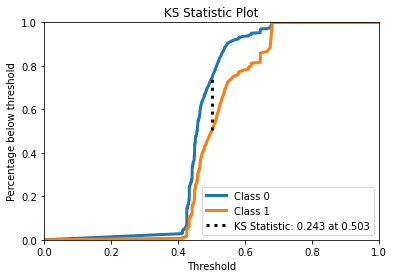


Accuracy:         0.6213
Recall:           0.5025
Precision:        0.6591
F1:               0.5703
AUROC:            0.6732
AUPR:             0.6696


In [16]:
gb_clf = GradientBoostingClassifier(n_estimators=10)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Primeiro testei variando o numero de estimadores pra ver o resultado

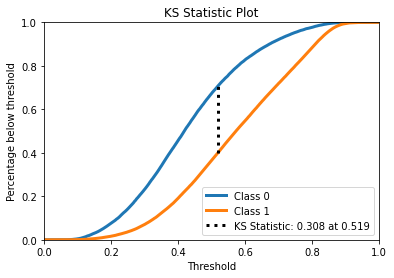


Accuracy:         0.6537
Recall:           0.6349
Precision:        0.6597
F1:               0.6471
AUROC:            0.7115
AUPR:             0.7055


In [17]:
gb_clf = GradientBoostingClassifier(learning_rate=0.5)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

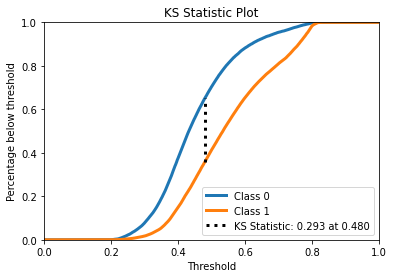


Accuracy:         0.6456
Recall:           0.5878
Precision:        0.6647
F1:               0.6239
AUROC:            0.7032
AUPR:             0.6965


In [18]:
gb_clf = GradientBoostingClassifier(learning_rate=0.05)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

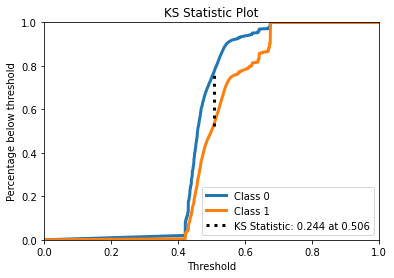


Accuracy:         0.6214
Recall:           0.4981
Precision:        0.6611
F1:               0.5681
AUROC:            0.6720
AUPR:             0.6717


In [19]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01)  
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Depois fiz testes variando o learning_rate